In [32]:
import numpy as np
import itertools
from recordclass import recordclass

import import_ipynb
from draw import board_to_svg

importing Jupyter notebook from draw.ipynb


Some rules have deliberately been excuded from this implementation :

* Loops in the game state are not checked (this speeds up considerably the computations and we never encountered a loop in practice)
* You are authorized to starve your opponent. This was made so the rules are a little bit simpler and should not change the complexity of the game.

The main method you are interested in is `Game.step(i)` to play the i-th pit in the current sate. This will return the new state, the amount of seeds captured and a boolean informing you if the game is finished.

On top of the simple implementation of Awalé, the `Game` class has a lot of helpers meant to be used by the MCTS algorithm and other agents.

* `view_from_current_player` shows you the pits from the view of the current player
* `legal_actions` gives you a list of the action the current player can make
* `is_fully_expanded` tells you if all actions of this state have been computed
* ...

In [66]:
GAME_NODE_FIELDS = [
    'n_pits', 'seeds_per_pit', 'pits', 'current_player',
    'captures', 'parent', 'children', 'wins', 'n_playouts'
]
        
class Game(recordclass('GameNode', GAME_NODE_FIELDS)):
    @classmethod
    def start_game(klass, n_pits=6, seeds_per_pit=4):
        return klass(
            n_pits,
            seeds_per_pit,
            pits=np.ones((n_pits * 2), dtype=int) * seeds_per_pit,
            current_player=0,
            captures=np.zeros((2,), dtype=int),
            parent=None,
            children=[None] * n_pits,
            wins=[0, 0],
            n_playouts=0
        )
    
    @property
    def view_from_current_player(self):
        if self.current_player == 0:
            return self.pits
        else:
            return np.roll(self.pits, self.n_pits)
    
    @property
    def current_player_pits(self):
        if self.current_player == 0:
            return self.pits[:self.n_pits]
        else:
            return self.pits[self.n_pits:]

    @property
    def legal_actions(self):
        # todo : add the Let the opponent play rule
        our_pits = self.current_player_pits
        return [x for x in range(self.n_pits) if our_pits[x] != 0]
    
    @property
    def successors(self):
        children = [x for x in self.children if x is not None]
        successors = children + list(itertools.chain(*[x.successors for x in children]))
        return successors

    def step(self, action):
        assert 0 <= action < self.n_pits, "Illegal action"
        
        # If we already did compute the children node, juste return it
        if self.children[action] is not None:
            new_game = self.children[action]
            captures = new_game.captures[self.current_player] - self.captures[self.current_player]
            return new_game, captures, new_game.game_finished
        
        target_pit = action if self.current_player == 0 else action - self.n_pits
        
        seeds = self.pits[target_pit]
        assert seeds != 0, "Illegal action: pit % is empty" % target_pit
        
        # copy attributes
        pits = np.copy(self.pits)
        captures = np.copy(self.captures)
        
        # empty the target pit
        pits[target_pit] = 0
        
        # fill the next pits
        pit_to_sow = target_pit
        while seeds > 0:
            pit_to_sow = (pit_to_sow + 1) % (self.n_pits * 2)
            if pit_to_sow != target_pit: # do not fill the target pit ever
                pits[pit_to_sow] += 1
                seeds -= 1
        
        # capture
        # count the captures of the play
        round_captures = 0
        if pit_to_sow in self.adverse_pits_idx:
            # if the last seed was in a adverse pit
            # we can try to collect seeds
            while pits[pit_to_sow] in (2, 3):
                # if the pit contains 2 or 3 seeds, we capture them
                captures[self.current_player] += pits[pit_to_sow]
                round_captures += pits[pit_to_sow]
                pits[pit_to_sow] = 0
                
                # go backwards
                pit_to_sow = (pit_to_sow - 1) % (self.n_pits * 2)
        
        # change player
        current_player = (self.current_player + 1) % 2
        
        new_game = type(self)(
            self.n_pits,
            self.seeds_per_pit,
            pits,
            current_player,
            captures,
            self,
            [None] * self.n_pits,
            [0, 0],
            0
        )
        
        self.children[action] = new_game
        return new_game, round_captures, new_game.game_finished
    
    @property
    def current_opponent(self):
        return (self.current_player + 1) % 2
    
    @property
    def adverse_pits_idx(self):
        if self.current_player == 1:
            return list(range(self.n_pits))
        else:
            return list(range(self.n_pits, self.n_pits * 2))
    
    @property
    def is_state_loop(self):
        return False
    
#     @property
#     def is_state_loop(self):
#         ancestor = self.parent
#         while ancestor is not None:
#             if np.all(ancestor.pits == self.pits):
#                 return True
#             ancestor = ancestor.parent
#         return False
    
    
    @property
    def game_finished(self):
        no_moves_left = np.count_nonzero(self.current_player_pits) == 0
        
        half_seeds = self.n_pits * self.seeds_per_pit
        enough_captures = self.captures[0] > half_seeds or self.captures[1] > half_seeds
        
        draw = self.captures[0] == half_seeds and self.captures[1] == half_seeds
        
        loop = self.is_state_loop
        
        return no_moves_left or enough_captures or draw or loop
    
    def show_state(self):
        if self.game_finished:
            print("Game finished")
        print("Current player: {} - Score: {}/{}\n{}".format(
            self.current_player,
            self.captures[self.current_player],
            self.captures[(self.current_player + 1) % 2],
            "-" * self.n_pits * 3
        ))
        
        pits = []
        for seeds in self.view_from_current_player:
            pits.append("{:3}".format(seeds))
        
        print("".join(reversed(pits[self.n_pits:])))
        print("".join(pits[:self.n_pits]))
    
    def update_stats(self, winner):
        assert winner in [0, 1]
        self.wins[winner] += 1
        self.n_playouts += 1
        if self.parent:
            self.parent.update_stats(winner)
    
    @property
    def winner(self):
        if not self.game_finished:
            return None
        return np.argmax(self.captures)
    
    @property
    def unvisited_actions(self):
        return [i for i, x in enumerate(self.children) if x is None]

    @property
    def legal_unvisited_actions(self):
        return list(set(self.unvisited_actions).intersection(set(self.legal_actions)))
    
    @property
    def expanded_children(self):
        return [x for x in self.children if x is not None]
    
    @property
    def is_fully_expanded(self):
        legal_actions = set(self.legal_actions)
        unvisited_actions = set(self.unvisited_actions)
        return len(legal_actions.intersection(unvisited_actions)) == 0
    
    @property
    def is_leaf_game(self):
        return self.children == [None] * self.n_pits
    
    @property
    def depth(self):
        if self.parent is None:
            return 0
        return 1 + self.parent.depth
    
    def __repr__(self):
        return "<Game {wins}/{n_playouts} player:{player} captures:{captures[0]}/{captures[1]}>".format(
            wins=self.wins,
            n_playouts=self.n_playouts,
            player=self.current_player,
            captures=self.captures
        )
    
    def _repr_svg_(self):
        board = np.array([
            list(reversed(self.pits[self.n_pits:])),
            self.pits[:self.n_pits]
        ])
        return board_to_svg(board, True)
        

### Usage

Here is an example of the usage of the API. We initialize a game and play the 5th pit

In [67]:
initial_state = Game.start_game()
new_state, captures, finished = initial_state.step(5)
new_state.current_player

1

Now that the current player is the number 1 (the second player) we play the 2nd pit and show the board in a human friendly manner

In [69]:
new_state, captures, finished = new_state.step(2)
new_state.show_state()

Current player: 1 - Score: 0/0
------------------
  1  5  5  0  5  5
  6  5  0  6  5  5


The pits are internaly represented as a numpy array, starting from the bottom left and going counter-clockwise to the top left

In [70]:
new_state.pits

array([5, 5, 0, 5, 5, 1, 6, 5, 0, 6, 5, 5])

The board can also be displayed as an SVG

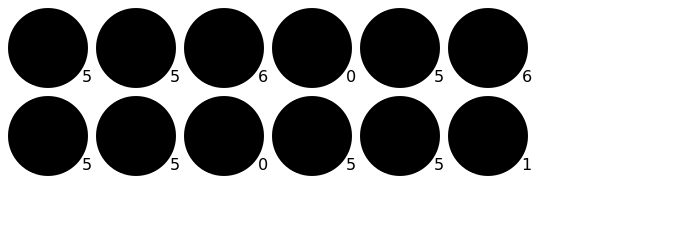

In [71]:
new_state